<a href="https://colab.research.google.com/github/ancastillar/MeLi_Test/blob/main/MeLi_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [444]:
!pip install minisom

!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 276 kB 5.8 MB/s 
     |████████████████████████████████| 9.8 MB 43.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Import Libraries

In [573]:
import requests
import pandas as pd
import numpy as np



import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


#------------------Data Processing
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection, DropHighPSIFeatures
import missingno as msno

from sklearn import preprocessing as prep

##-----------------Clustering

from minisom import MiniSom 
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans

import pickle
import joblib



#---------------General Configuration

pd.options.display.max_columns = 500
sns.set_context("paper", font_scale=1.9)
plt.rcParams["figure.figsize"] = (20,20)
from matplotlib.gridspec import GridSpec
%matplotlib inline

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global definitions

In [574]:
countries_codes = [
 "MPY",
"MCO",
"MCU",
"MLB",
"MEC",
"MCR",
"MRD",
"MHN",
"MLA",
"MGT",
"MSV",
"MLC",
"MNI",
"MPE",
"MPA",
"MBO",
"MLV",
"MLM",
"MLU"]

print(len(countries_codes))
#------------------------------------------------------------------------------------------------------------------------------------------

def dic_to_cols(df_aux, list_cols, variable_dic, var_aux):
  

  if variable_dic!="reference_prices_aux":
    for col in list_cols:

      df_aux[col+var_aux] = df_aux[variable_dic].apply(lambda x: x[col] if x!=None else None)
  
  else:
   for col in list_cols:

      df_aux[col+var_aux] = df_aux[variable_dic].apply(lambda x: x[0][col] if x!=None else None)

  return df_aux

#------------------------------------------------------------------------------------------------------------------------------------------

data_path = "/content/drive/MyDrive/MeLi_prueba/data/"
models_path = "/content/drive/MyDrive/MeLi_prueba/models/"

19


## Extract categories for each country

In [351]:
json_categories = {}

for country_code in countries_codes:

  url_cat = f'https://api.mercadolibre.com/sites/{country_code}/categories'
  json_categories[country_code] = pd.DataFrame(requests.get(url_cat).json())

## Extract info for specific Country: Stratify Sampling per category id

I'm going to make the analysis only for **Colombia**

In [354]:
id_country = "MCO"
ids_categories = json_categories[id_country]["id"]

print("Amount of categories:",ids_categories.shape)

Amount of categories: (32,)


In [356]:
%%time

df_total = pd.DataFrame(columns=[])



for cat_id in ids_categories:

  for ofset in np.arange(0,1050, 50):

      url = f'https://api.mercadolibre.com/sites/{id_country}/search?category={cat_id}&offset={ofset}'

      
      request = requests.get(url)
      
      items = request.json()
      
      if "results" in items.keys(): 

        df_results = pd.DataFrame(items["results"])

        df_results["category_id_org"] = cat_id

        df_total = pd.concat([df_total,df_results], axis=0)
        


df_total.to_parquet(data_path+"data_categories_filter.parquet")

CPU times: user 2min 12s, sys: 1.89 s, total: 2min 14s
Wall time: 14min 14s


In [357]:
print("Dimension of dataframe:",df_total.shape)

Dimension of dataframe: (33510, 42)


In [358]:
df_total.head(5)

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,buying_mode,listing_type_id,stop_time,condition,permalink,thumbnail,thumbnail_id,accepts_mercadopago,installments,address,shipping,seller_address,attributes,original_price,category_id,official_store_id,domain_id,catalog_product_id,tags,order_backend,use_thumbnail_id,offer_score,offer_share,match_score,winner_item_id,melicoin,discounts,differential_pricing,catalog_listing,category_id_org,seller_contact,location
0,MCO464124554,MCO,Combo 2 Forros Protector Sillas Carro Auto Mas...,"{'id': 152737872, 'permalink': None, 'registra...",56900.0,"{'id': 'MCO464124554', 'prices': [{'id': '25',...",None,COP,500,500,buy_it_now,gold_special,2040-10-22T15:30:20.000Z,new,https://articulo.mercadolibre.com.co/MCO-46412...,http://http2.mlstatic.com/D_646062-MCO43036011...,646062-MCO43036011644_082020,True,"{'quantity': 36, 'amount': 1580.56, 'rate': 0,...","{'state_id': 'CO-DC', 'state_name': 'Bogotá D....","{'free_shipping': False, 'mode': 'me2', 'tags'...","{'id': '', 'comment': '', 'address_line': '', ...","[{'name': 'Marca', 'value_id': None, 'value_na...",NaN,MCO178000,NaN,MCO-CAR_SEAT_COVERS,None,"[dragged_bids_and_visits, good_quality_picture...",1,True,None,None,None,None,None,None,NaN,NaN,MCO1747,NaN,NaN
1,MCO565095458,MCO,Pomo Pera Palanca De Cambios Renault Logan San...,"{'id': 46210745, 'permalink': None, 'registrat...",28000.0,"{'id': 'MCO565095458', 'prices': [{'id': '1', ...",None,COP,1,500,buy_it_now,gold_pro,2040-05-29T04:00:00.000Z,new,https://articulo.mercadolibre.com.co/MCO-56509...,http://http2.mlstatic.com/D_766098-MCO49954362...,766098-MCO49954362516_052022,True,"{'quantity': 12, 'amount': 2333.33, 'rate': 0,...","{'state_id': 'CO-DC', 'state_name': 'Bogotá D....","{'free_shipping': False, 'mode': 'me2', 'tags'...","{'id': '', 'comment': '', 'address_line': '', ...","[{'value_struct': None, 'attribute_group_id': ...",NaN,MCO376787,NaN,MCO-LIGHT_VEHICLE_PARTS,None,"[good_quality_thumbnail, loyalty_discount_elig...",2,True,None,None,None,None,None,None,{'id': 33602181},NaN,MCO1747,NaN,NaN
2,MCO825255064,MCO,Impermeable Siliconado Para Motociclista,"{'id': 498209073, 'permalink': None, 'registra...",55385.0,"{'id': 'MCO825255064', 'prices': [{'id': '26',...",None,COP,150,500,buy_it_now,gold_special,2041-10-21T04:00:00.000Z,new,https://articulo.mercadolibre.com.co/MCO-82525...,http://http2.mlstatic.com/D_830062-MCO45474645...,830062-MCO45474645366_042021,True,"{'quantity': 36, 'amount': 1538.47, 'rate': 0,...","{'state_id': 'CO-DC', 'state_name': 'Bogotá D....","{'free_shipping': False, 'mode': 'me2', 'tags'...","{'id': '', 'comment': '', 'address_line': '', ...","[{'id': 'BRAND', 'value_id': None, 'value_name...",58300.0,MCO90075,NaN,MCO-MOTORCYCLE_RAIN_SUITS,None,"[good_quality_picture, good_quality_thumbnail,...",3,True,None,None,None,None,None,None,NaN,NaN,MCO1747,NaN,NaN
3,MCO865524965,MCO,"Radio Para Carro Jdl Jdl-5303 Con Usb, Bluetoo...","{'id': 62840024, 'permalink': None, 'registrat...",92900.0,"{'id': 'MCO865524965', 'prices': [{'id': '156'...",None,COP,3,338,buy_it_now,gold_special,2042-02-25T04:00:00.000Z,new,https://www.mercadolibre.com.co/radio-para-car...,http://http2.mlstatic.com/D_799836-MLA48110981...,799836-MLA48110981644_112021,True,"{'quantity': 36, 'amount': 2580.56, 'rate': 0,...","{'state_id': 'CO-DC', 'state_name': 'Bogotá D....","{'free_shipping': True, 'mode': 'me2', 'tags':...","{'id': '', 'comment': '', 'address_line': '', ...","[{'name': 'Marca', 'value_id': '10477073', 'va...",99900.0,MCO441982,NaN,MCO-VEHICLE_STEREOS,MCO18554637,"[good_quality_picture, immediate_payment, cart...",4,True,None,None,None,None,None,None,NaN,True,MCO1747,NaN,NaN
4,MCO508601525,MCO,Forro Sillas Funda Protector Mascota Cobertor ...,"{'id': 152737872, 'permalink': None, 'registra...",46900.0,"{'id': 'MCO508601525', 'prices': [{'id': '23',...",None,COP,1,500,buy_it_now,gold_special,2039-03-28T04:00:00.000Z,new,https://articulo

# DataFrame Construcction: Colombia


In [512]:
df = pd.read_parquet(data_path+"data_categories_filter.parquet").drop(["title", "site_id", "permalink","location", "currency_id", "stop_time","thumbnail", "thumbnail_id", "official_store_id",	"domain_id",
                                                                       "seller_address","winner_item_id", "offer_score","category_id", "catalog_listing",	"catalog_product_id", "offer_share", "match_score", "differential_pricing", "attributes"], axis=1).reset_index(drop=True).rename(columns={"prices":"prices_", "id":"id_item"})


df = df.reset_index(drop=True)

print("Dimension of dataframe:", df.shape)

Dimension of dataframe: (33510, 22)


## Some Data Preprocessing 

In [513]:
list_cols_seller = ["car_dealer", "eshop", "home_image_url", "id", "permalink", "real_estate_agency", "registration_date", "seller_reputation", "tags" ]


df = dic_to_cols(df, list_cols_seller, "seller", "_seller")

#-------------------------------------Prices-------------------------------------------------------------------------------------------------------

list_prices_cols = [ 'reference_prices']


df = dic_to_cols(df, list_prices_cols , "prices_", "_aux")

#-----------------------------------Installments------------------------------------------------------------------------------------------------------

list_install_cols = ['amount', 'quantity', 'rate']

df = dic_to_cols(df, list_install_cols , "installments", "_help_pay")


#--------------------------------------Shipping--------------------------------------------------------------------------------------------------------

list_shipping_cols =['free_shipping', 'logistic_type',  'store_pick_up',]

df = dic_to_cols(df, list_shipping_cols , "shipping", "_ship")

#----------------------------------------------------Prices&ReferencePrices----------------------------------------------------------------------------

df = dic_to_cols(df,["amount"], "reference_prices_aux", "_reference_p")




#----------------------------------------------Address-------------------------------------------------------------------------------------------------

df = dic_to_cols(df,["state_name"], "address", "_")


#------------------------------------------------------------------------#df_total.to_parquet(data_path+"data_categories_filter.parquet")-------------------------------------------------------------------------------

drop_columns = ["seller", "prices_", "installments", "shipping", "reference_prices_aux", "address"]

df = df.drop(drop_columns, axis=1)


#------------------------------------------------------------------------------------------------------------------------------------------------------

df["price_greater_reference"] =  np.where(df['price']>df["amount_reference_p"], 1,0)

bool_cols = ["use_thumbnail_id", "free_shipping_ship", "store_pick_up_ship", "accepts_mercadopago"]
"category_id_org"
for col in bool_cols:

  df[col] =  df[col].apply(lambda x: 1 if x==True else 0)




df = df.drop_duplicates("id_item")

print("Dimension of dataframe without items duplicates", df.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



Dimension of dataframe without items duplicates (31134, 35)


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31257 entries, 0 to 33535
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id_item                    31257 non-null  object 
 1   price                      30676 non-null  float64
 2   sale_price                 0 non-null      object 
 3   available_quantity         31257 non-null  int64  
 4   sold_quantity              31257 non-null  int64  
 5   buying_mode                31257 non-null  object 
 6   listing_type_id            31257 non-null  object 
 7   condition                  30207 non-null  object 
 8   accepts_mercadopago        31257 non-null  bool   
 9   original_price             3482 non-null   float64
 10  category_id                31257 non-null  object 
 11  tags                       31257 non-null  object 
 12  order_backend              31257 non-null  int64  
 13  use_thumbnail_id           31257 non-null  int

We have a lot of null values for the specific information of sellers, and this information is important for a better understanding of Meli business. Therefore, we are going to extract this information with a new request.

In [514]:
df = df.drop(["melicoin", "discounts","sale_price","car_dealer_seller", "eshop_seller", "home_image_url_seller","permalink_seller", "real_estate_agency_seller", "registration_date_seller", "seller_reputation_seller", "tags_seller" ], axis=1)

In [208]:
df.head(10)

,id_item,price,available_quantity,sold_quantity,buying_mode,listing_type_id,condition,accepts_mercadopago,original_price,category_id,tags,order_backend,use_thumbnail_id,seller_contact,id_seller,amount_help_pay,quantity_help_pay,rate_help_pay,free_shipping_ship,logistic_type_ship,store_pick_up_ship,amount_reference_p,state_name_,price_greater_reference
0,MCO464124554,56900.0,500,500,buy_it_now,gold_special,new,True,NaN,MCO178000,"[good_quality_picture, good_quality_thumbnail,...",1,1,None,152737872,1580.56,36.0,0.0,0,cross_docking,0,56900.0,Bogotá D.C.,0
1,MCO565095458,28000.0,1,500,buy_it_now,gold_pro,new,True,NaN,MCO376787,"[loyalty_discount_eligible, good_quality_pictu...",2,1,None,46210745,2333.33,12.0,0.0,0,fulfillment,0,NaN,Bogotá D.C.,0
2,MCO825255064,55385.0,150,500,buy_it_now,gold_special,new,True,58300.0,MCO90075,"[good_quality_picture, good_quality_thumbnail,...",3,1,None,498209073,1538.47,36.0,0.0,0,xd_drop_off,0,57600.0,Bogotá D.C.,0
3,MCO865524965,90900.0,3,338,buy_it_now,gold_special,new,True,99900.0,MCO441982,"[good_quality_picture, immediate_payment, cart...",4,1,None,62840024,2525.00,36.0,0.0,1,fulfillment,0,86126.0,Bogotá D.C.,1
4,MCO508601525,46900.0,1,500,buy_it_now,gold_special,new,True,NaN,MCO178000,"[loyalty_discount_eligible, good_quality_pictu...",5,0,None,152737872,1302.78,36.0,0.0,0,fulfillment,0,46900.0,Bogotá D.C.,0
5,MCO460468229,34900.0,50,500,buy_it_now,gold_special,new,True,NaN,MCO373291,"[good_quality_picture, good_quality_thumbnail,...",6,1,None,31508529,969.44,36.0,0.0,0,cross_docking,0,33700.0,Bogotá D.C.,1
6,MCO595223443,89900.0,500,500,buy_it_now,gold_special,new,True,NaN,MCO173788,"[good_quality_picture, good_quality_thumbnail,...",7,1,None,216893546,2497.22,36.0,0.0,1,drop_off,0,80910.0,Tolima,1
7,MCO529735464,34900.0,250,500,buy_it_now,gold_special,new,True,45900.0,MCO178000,"[good_quality_picture, good_quality_thumbnail,...",9,0,None,23439548,969.44,36.0,0.0,0,cross_docking,0,45900.0,Cundinamarca,0
8,MCO657194875,314900.0,10,151,buy_it_now,gold_special,new,True,NaN,MCO441982,"[good_quality_picture, loyalty_discount_eligib...",10,1,None,353899337,8747.22,36.0,0.0,1,cross_docking,0,297668.0,Bogotá D.C.,1
9,MCO852377181,80161.0,20,10,buy_it_now,gold_special,new,True,NaN,MCO370796,"[good_quality_picture, immediate_payment, cart...",11,1,None,471793327,2226.69,36.0,0.0,1,fulfillment,0,76062.0,Bogotá D.C.,1


## Get seller Information

In [363]:
%%time

list_id_sellers = list(df["id_seller"].unique())


df_total = pd.DataFrame(index=range(0,len(list_id_sellers)), columns=["seller", "id_seller"])

i=0

for id_seller in list_id_sellers:
  
  url = f'https://api.mercadolibre.com/sites/{id_country}/search?seller_id={id_seller}&attributes=results.seller'

  request = requests.get(url)
  items = request.json()
  
  if "results" in items.keys(): 

        df_total.at[i,"id_seller"] = id_seller
        df_total.at[i,"seller"] = items["results"]
  i=i+1


df_total.to_parquet(data_path+"data_sellers_info.parquet")

CPU times: user 1min 33s, sys: 5.84 s, total: 1min 39s
Wall time: 20min 1s


In [ ]:
###Total information: Optional, if you want to perfomr a depper analysis with all the items for each client
#######We are doing a Baseline exploration therefore the following line are no necessary

"""%%time

df_total = pd.DataFrame(columns=[])


for id_seller in list_id_sellers:

      url =  f'https://api.mercadolibre.com/sites/{id_country}/search?seller_id={id_seller}'

      request = requests.get(url)
      
      items = request.json()
      
      if "results" in items.keys(): for col in list_cols:
      
        df_total = pd.concat([df_total,pd.DataFrame(items["results"])], axis=0)

df_total.to_parquet(data_path+"data_sellers_info_total.parquet")"""

##Join with items informations

In [515]:
df_total["seller_"] = df_total["seller"].apply(lambda x: x[0]["seller"] if len(x)>1 else None)

In [524]:
df_= df.merge(df_total, on="id_seller", how="left").drop_duplicates("id_item").drop("seller", axis=1)

df_ = df_.merge(json_categories["MCO"].rename(columns={"id":"category_id_org"}), on=["category_id_org"], how="left").drop_duplicates("id_item")
#----------------------------------------------------------------------------------------------------------------------------

list_cols_seller = ['permalink', 'registration_date',  'seller_reputation']

df_ = dic_to_cols(df_,list_cols_seller, "seller_", "_seller")

#------------------------------------------Seller reputation-----------------------------------------------------------------

list_cols_seller_status = ['power_seller_status', 'level_id', 'metrics', 'transactions']

df_ = dic_to_cols(df_,list_cols_seller_status, "seller_reputation_seller", "_seller")


#--------------------------Metrics Seller---------------------------------------------------------------------------------------

list_cols_metrics_sellers = ['cancellations', 'claims', 'delayed_handling_time', 'sales']


df_ = dic_to_cols(df_,list_cols_metrics_sellers , "metrics_seller", "_seller")

#-----------------------------Transacctions_Seller--------------------------------------------------------------------------------------

list_cols_trans_sellers = ['canceled', 'period', 'total', 'ratings', 'completed']


df_ = dic_to_cols(df_,list_cols_trans_sellers , "transactions_seller", "_trans_seller")




#--------------------------------------Cancellations_Seller-----------------------------------------------------------------------


list_cols_cancellations_sellers  = ['period', 'rate', 'value']

df_ = dic_to_cols(df_,list_cols_cancellations_sellers  , "cancellations_seller", "_cancell_seller")



#-------------------------------------Claims_Seller--------------------------------------------------------------------------------

list_cols_claims_sellers  = ['period', 'rate', 'value']

df_ = dic_to_cols(df_,list_cols_claims_sellers  , "claims_seller", "_claims_seller")


#------------------------------------------Delayed Seller---------------------------------------------------------------------------


list_cols_delay_sellers  = ['period', 'rate', 'value']

df_ = dic_to_cols(df_,list_cols_delay_sellers  , "delayed_handling_time_seller", "_delayed_seller")


#--------------------------------------------Sales Seller-------------------------------------------------------------------------------------------

list_cols_sales_sellers  = ['period', 'completed']

df_ = dic_to_cols(df_,list_cols_sales_sellers  , "sales_seller", "_sales_seller")


#--------------------------------------------Ratinds Seller-------------------------------------------------------------------------------------------

list_cols_ratings_seller = ['negative', 'neutral', 'positive']

df_ = dic_to_cols(df_, list_cols_ratings_seller  , "ratings_trans_seller", "_rating_seller")

#-----------------------------------------------permalink_seller

df_["permalink_seller"] = df_["permalink_seller"].apply(lambda x: 1 if x!=None else 0)

df_["date_today"] =  pd.to_datetime("today", errors='coerce', format="%Y-%m-%d", utc=True,exact=False)

df_['registration_date_seller'] = pd.to_datetime(df_['registration_date_seller'], errors='coerce', format="%Y-%m-%d",utc=True,exact=False)



df_["age_seller_months"] = (df_['date_today'] - df_['registration_date_seller'])/ np.timedelta64(1, 'M')


df_ = df_.drop(["seller_", "metrics_seller","seller_reputation_seller", "transactions_seller","claims_seller",  "cancellations_seller", "sales_seller",
                "delayed_handling_time_seller", "ratings_trans_seller", "registration_date_seller", "date_today","category_id_org", "period_sales_seller", "period_claims_seller", 
                "period_cancell_seller", "period_cancell_seller", "seller_contact",	 "period_trans_seller","period_delayed_seller"], axis=1)

print("Dimensioon final dataset:", df_.shape)

Dimensioon final dataset: (31134, 40)


In [425]:
df_.head(5)

,id_item,price,sale_price,available_quantity,sold_quantity,buying_mode,listing_type_id,condition,accepts_mercadopago,original_price,tags,order_backend,use_thumbnail_id,melicoin,discounts,car_dealer_seller,eshop_seller,home_image_url_seller,permalink_seller,real_estate_agency_seller,tags_seller,amount_help_pay,quantity_help_pay,rate_help_pay,free_shipping_ship,logistic_type_ship,store_pick_up_ship,amount_reference_p,state_name_,price_greater_reference,name,power_seller_status_seller,level_id_seller,canceled_trans_seller,period_trans_seller,total_trans_seller,completed_trans_seller,rate_cancell_seller,value_cancell_seller,rate_claims_seller,value_claims_seller,period_delayed_seller,rate_delayed_seller,value_delayed_seller,completed_sales_seller,negative_rating_seller,neutral_rating_seller,positive_rating_seller,age_seller_months
0,MCO464124554,56900.0,None,500,500,buy_it_now,gold_special,new,1,NaN,"[dragged_bids_and_visits, good_quality_picture...",1,1,None,None,False,None,None,1,False,None,1580.56,36.0,0.0,0,cross_docking,0,56900.0,Bogotá D.C.,0,Accesorios para Vehículos,platinum,5_green,186.0,historic,8719.0,8533.0,0.0000,1.0,0.0040,5.0,60 days,0.0024,3.0,1200.0,0.01,0.01,0.98,101.155173
1,MCO565095458,28000.0,None,1,500,buy_it_now,gold_pro,new,1,NaN,"[good_quality_thumbnail, loyalty_discount_elig...",2,1,None,None,False,None,None,1,False,None,2333.33,12.0,0.0,0,fulfillment,0,NaN,Bogotá D.C.,0,Accesorios para Vehículos,platinum,5_green,369.0,historic,12221.0,11852.0,0.0022,5.0,0.0050,11.0,60 days,0.0083,18.0,2145.0,0.01,0.01,0.98,136.314821
2,MCO825255064,55385.0,None,150,500,buy_it_now,gold_special,new,1,58300.0,"[good_quality_picture, good_quality_thumbnail,...",3,1,None,None,False,None,None,1,False,None,1538.47,36.0,0.0,0,xd_drop_off,0,57600.0,Bogotá D.C.,0,Accesorios para Vehículos,platinum,5_green,276.0,historic,7822.0,7546.0,0.0000,1.0,0.0110,22.0,60 days,0.1321,255.0,1913.0,0.06,0.02,0.92,30.628572
3,MCO865524965,92900.0,None,3,338,buy_it_now,gold_special,new,1,99900.0,"[good_quality_picture, immediate_payment, cart...",4,1,None,None,False,None,None,1,False,None,2580.56,36.0,0.0,1,fulfillment,0,86126.0,Bogotá D.C.,1,Accesorios para Vehículos,platinum,5_green,1250.0,historic,32850.0,31600.0,0.0049,23.0,0.0155,73.0,60 days,0.0042,19.0,4514.0,0.04,0.02,0.94,161.669927
4,MCO508601525,46900.0,None,1,500,buy_it_now,gold_special,new,1,NaN,"[good_quality_picture, good_quality_thumbnail,...",5,0,None,None,False,None,None,1,False,None,1302.78,36.0,0.0,0,fulfillment,0,46900.0,Bogotá D.C.,0,Accesorios para Vehículos,platinum,5_green,186.0,historic,8719.0,8533.0,0.0000,1.0,0.0040,5.0,60 days,0.0024,3.0,1200.0,0.01,0.01,0.98,101.155173


#EDA

###Mean of price for each state and listing type id

Text(0.5, 1.0, 'Mean of price for each state and listing type id')

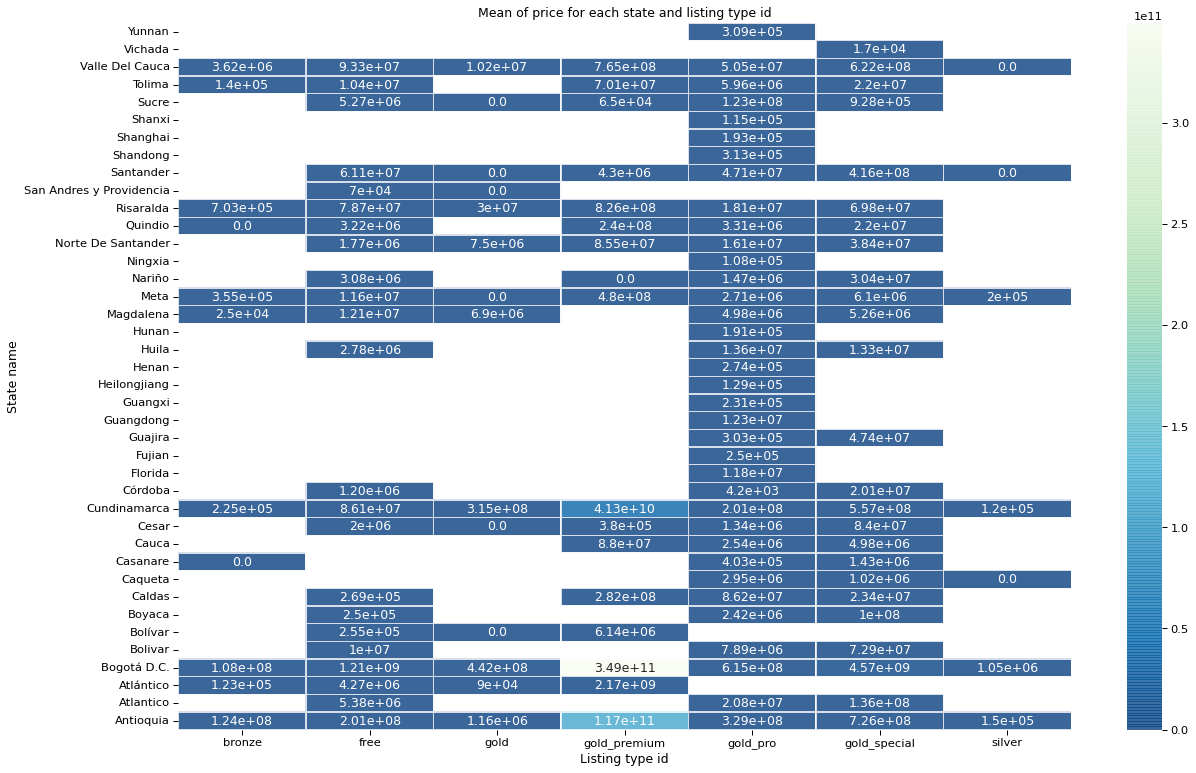

In [405]:
plt.rcParams["figure.figsize"] = (20,13)
a = df_.groupby([ "state_name_",  "listing_type_id"]).sum()["price"].reset_index()\
                .pivot( "state_name_",  "listing_type_id","price")\
                .sort_index(ascending=False)


sns.heatmap(a,
            cmap="GnBu_r", annot=True, linewidths=0.2, alpha=0.8, fmt=".3")
 
plt.ylabel("State name")
plt.xlabel("Listing type id")
 
plt.title("Mean of price for each state and listing type id")

###Sold quantity for each client type

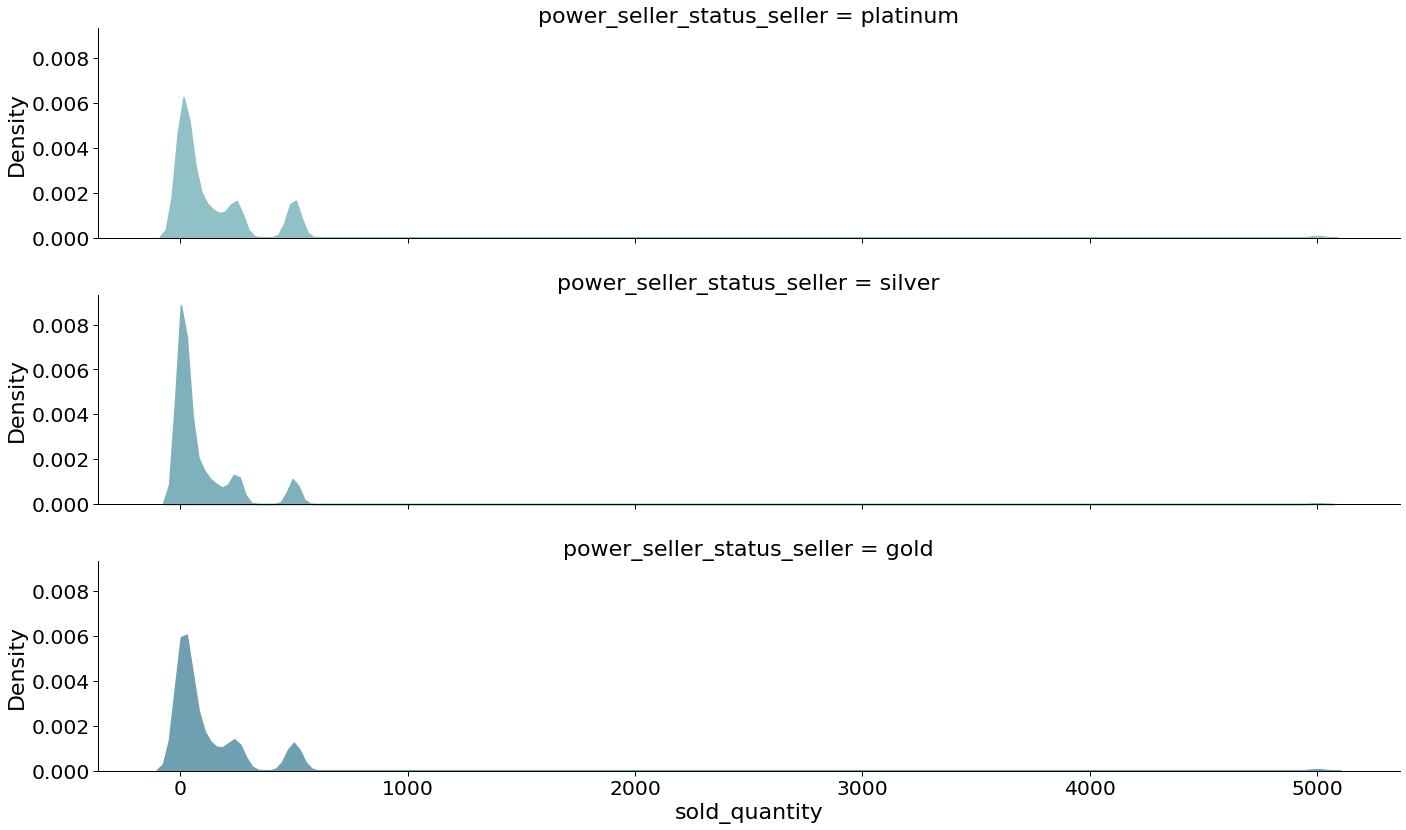

In [407]:
# Initialize the FacetGrid object
sns.set_context("paper", font_scale=2.3)
plt.rcParams["figure.figsize"] = (15,3)

pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

g = sns.FacetGrid(df_, row="power_seller_status_seller", hue="power_seller_status_seller", aspect=5, height=4, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "sold_quantity",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)


### Distribution of ratings for each seller

Text(0.5, 1.0, 'Amount of sellers in each bin of positive rating')

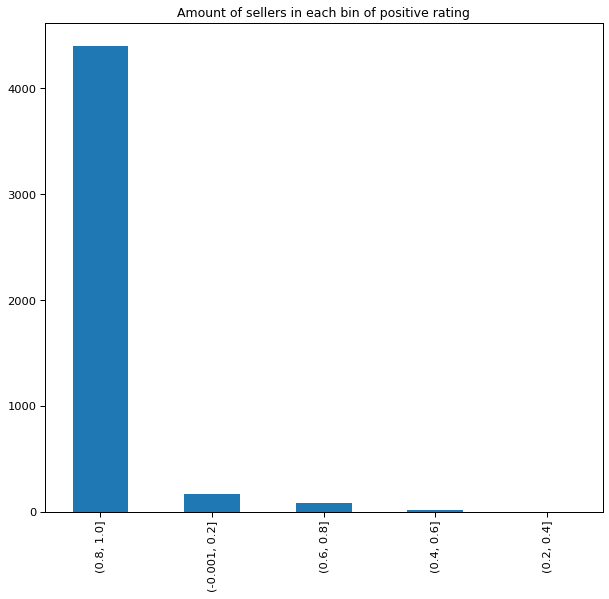

In [393]:
plt.rcParams["figure.figsize"] = (10,9)

df_.drop_duplicates("id_seller")["positive_rating_seller_bin"].value_counts().plot(kind="bar")
plt.title("Amount of sellers in each bin of positive rating")

###Mean of price for each category name and seller classification

Text(0.5, 1.0, 'Mean of price for each category name and seller classification')

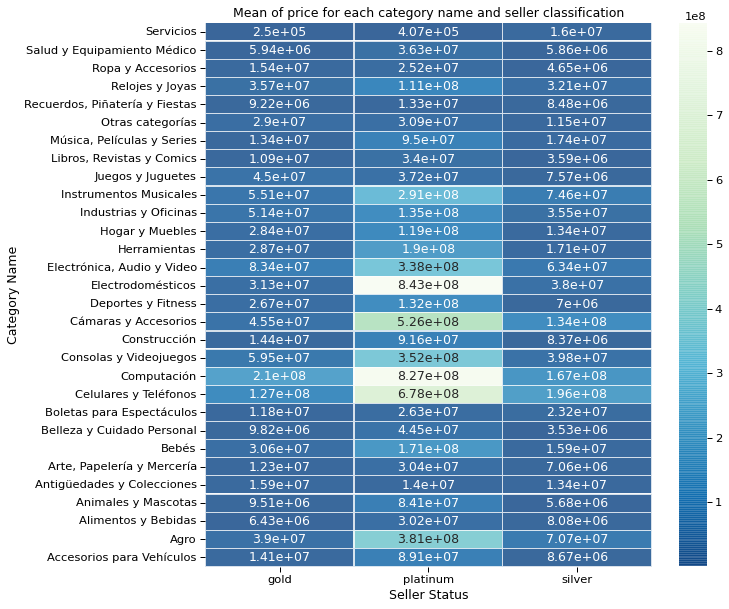

In [409]:
plt.rcParams["figure.figsize"] = (10,10)
a = df_.groupby([ "name",  "power_seller_status_seller"]).sum()["price"].reset_index()\
                .pivot( "name",  "power_seller_status_seller","price")\
                .sort_index(ascending=False)


sns.heatmap(a,
            cmap="GnBu_r", annot=True, linewidths=0.2, alpha=0.8, fmt=".3")
 
plt.ylabel("Category Name")
plt.xlabel("Seller Status")
 
plt.title("Mean of price for each category name and seller classification")

In [402]:
a = df_.groupby(["name", "price_greater_reference"]).agg({"sold_quantity": "mean"}).reset_index().rename(columns={"sold_quantity": "mean_sold_quantity"})
fig = px.bar(a, x="name", y="mean_sold_quantity", color="price_greater_reference", title = "Mean of sold quantity for each category name", color_discrete_sequence=px.colors.qualitative.T10,  opacity=0.5,)

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Category Name')car_dealer_seller
fig.update_yaxes(title_text="Mean of sold quantity")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

### Correlation Analysis

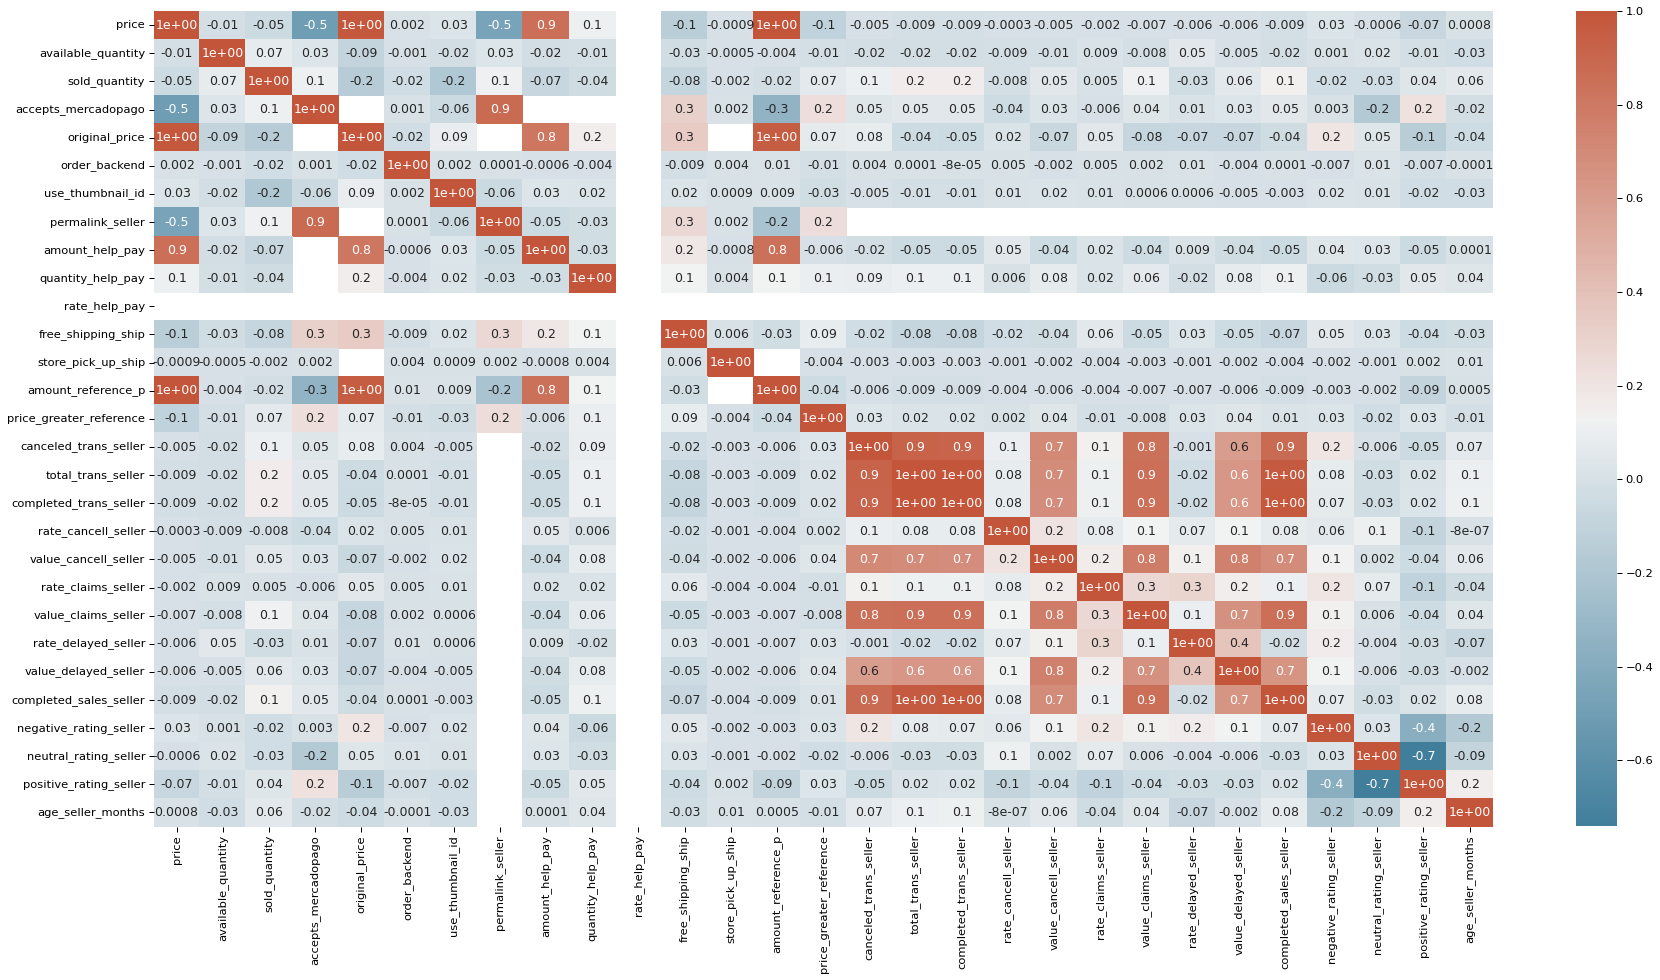

In [442]:
plt.rcParams["figure.figsize"] = (30,15)
df_num = df_.select_dtypes(exclude="object")
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#
# Draw the heatmap
#
sns.heatmap(df_num.corr(), annot=True, cmap=cmap, fmt=".1")

### Creation of some new variables

In [525]:
df_["diff_price_reference"] = df_["price"]- df_['amount_reference_p']
df_["pcte_price_amount_help"] = df_["amount_help_pay"]/df_["price"]


###---Posible target for the model

df_["sold_quantity_rate"] = df_["sold_quantity"]/(df_["sold_quantity"]+ df_["available_quantity"])

###Searching Constant features

In [477]:
const = DropConstantFeatures(tol=0.9, missing_values="include")
const.fit(df_num)
const.features_to_drop_

['use_thumbnail_id', 'store_pick_up_ship']

###Searching high correlations between variables

In [455]:
corr = SmartCorrelatedSelection(threshold=0.85)

corr.fit(df_num)


drop_vars_corr = corr.features_to_drop_


corr.correlated_feature_sets_ ### explicabilidad con respecto al target

[{'amount_help_pay', 'amount_reference_p', 'original_price', 'price'},
 {'accepts_mercadopago', 'permalink_seller'},
 {'canceled_trans_seller',
  'completed_sales_seller',
  'completed_trans_seller',
  'total_trans_seller'}]

In [526]:
drop_vars = const.features_to_drop_ + drop_vars_corr 
df_ = df_.drop(drop_vars, axis=1)

In [527]:
print("Dimenson of dataset:", df_.shape)

Dimenson of dataset: (31134, 34)


### Null Values Analysis

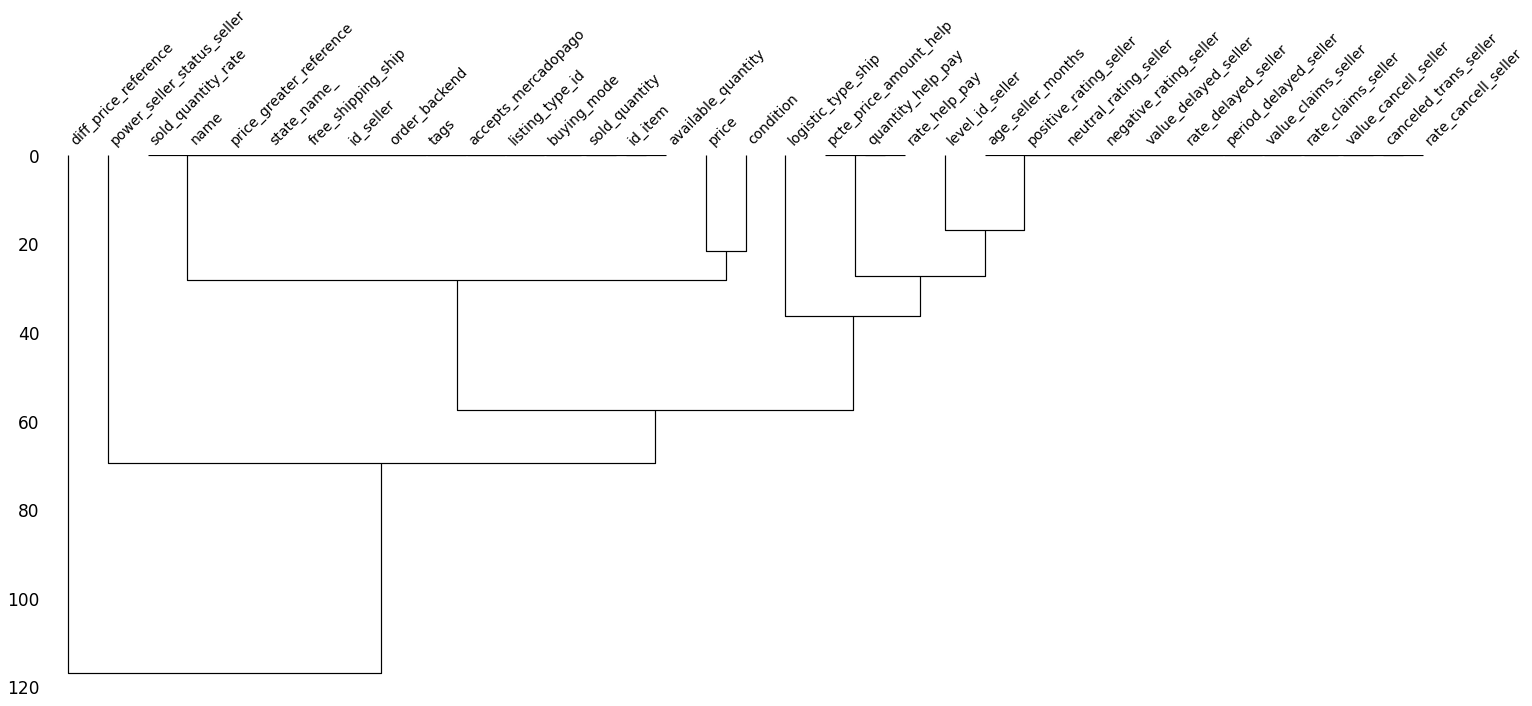

In [520]:
msno.dendrogram(df_,fontsize=14)

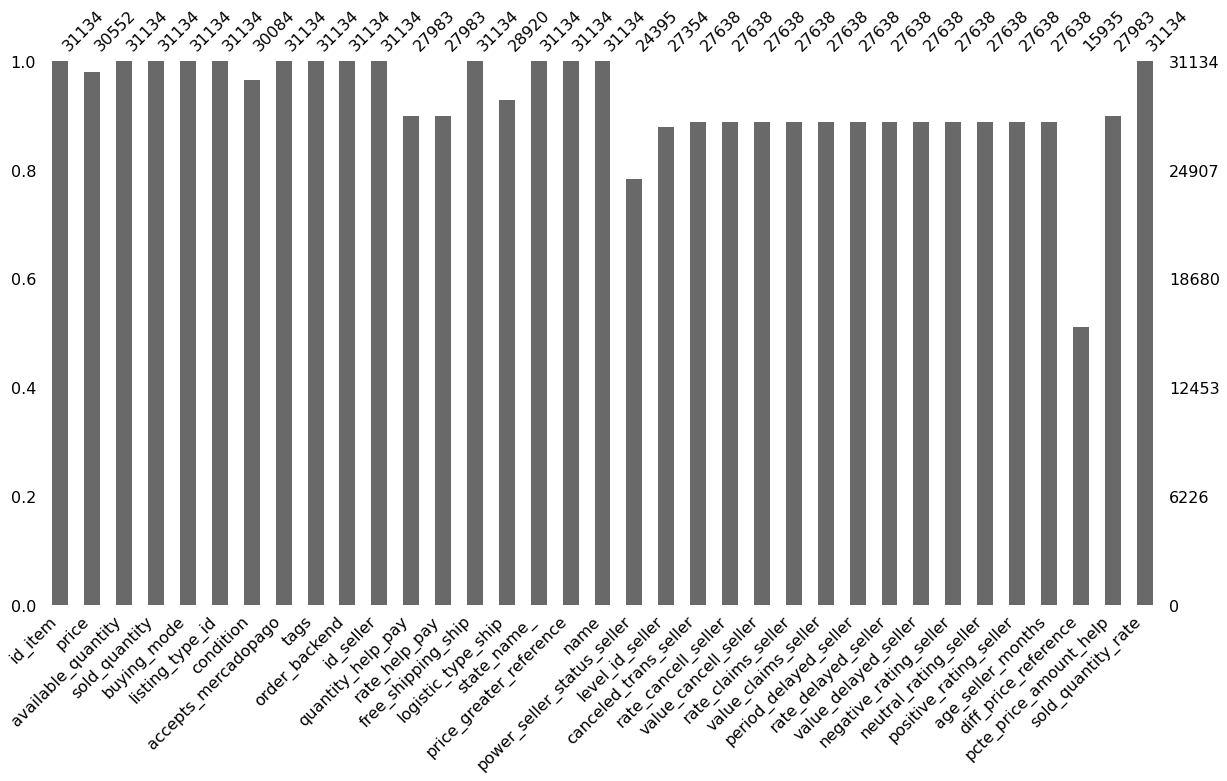

In [521]:
msno.bar(df_, figsize=(20, 10))

### Save Data

In [528]:
df_.to_parquet(data_path+"data_to_model.parquet")

#Seller Clustering 

In [558]:
df_ = pd.read_parquet(data_path+"data_to_model.parquet")

In [559]:
df_ = df_.drop(["id_item"], axis=1)
df_aux = pd.get_dummies(df_[["power_seller_status_seller","level_id_seller"]], drop_first=True)
df_ = pd.concat([df_, df_aux], axis=1)


In [571]:
df_sellers = df_.groupby(["id_seller"]).agg({"price":"mean", "available_quantity":"mean", "sold_quantity":"mean",  "listing_type_id":"nunique",
                                "condition":"nunique", "accepts_mercadopago":"sum", "order_backend":"sum","quantity_help_pay":"mean", "rate_help_pay":"mean",
                                 "free_shipping_ship":"sum", "logistic_type_ship":"nunique",  "state_name_": "nunique",
                                "price_greater_reference": "sum","name": "nunique", "diff_price_reference":"mean","pcte_price_amount_help":"mean",
                                "sold_quantity_rate":"mean","canceled_trans_seller":"mean",	"rate_cancell_seller":"mean",	"value_cancell_seller":"mean",
                                "rate_claims_seller":"mean","value_claims_seller":"mean",	"rate_delayed_seller":"mean",
                                "value_delayed_seller":"mean",	"negative_rating_seller":"mean","neutral_rating_seller":"mean",
                                "positive_rating_seller":"mean",	"age_seller_months":"mean",
                                "power_seller_status_seller_platinum":"first",	"power_seller_status_seller_silver":"first","level_id_seller_2_orange":"first",	
                                "level_id_seller_3_yellow": "first", "level_id_seller_4_light_green":"first",	"level_id_seller_5_green":"first"})


columns_selllers = df_sellers.columns

### Run Clustering Kmeans

In [572]:
df_sellers = df_sellers.fillna(-999)

sc = prep.StandardScaler()

a= sc.fit(df_sellers)


df_cluster = pd.DataFrame(sc.fit_transform(df_sellers), columns=columns_selllers)

In [597]:
df_cluster_sample =df_cluster
n_clusters = [3,4,5,6,7,8,9,10,11,12,13,14,15,16]

labels_kmeans = {}
centroids_kmeans = {}
scores_kmeans = {}
k_means_models = {}

for cluster in n_clusters:
  
  k_means= (KMeans(n_clusters = cluster ,init='k-means++' ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='full') )
  
  k_means.fit_predict(df_cluster_sample)
  k_means_models[str(cluster)] =k_means
  labels_kmeans[str(cluster)] = k_means.labels_
  centroids_kmeans[str(cluster)] = k_means.cluster_centers_
  scores_kmeans[str(cluster)] = silhouette_score( df_cluster_sample,k_means.labels_, metric='euclidean')



In [598]:
si_scores = pd.DataFrame(list(scores_kmeans.values()), columns = ["silhouette_score"], index=n_clusters)
si_scores = si_scores.loc[:16]
si_scores.sort_values(by="silhouette_score", ascending=False, inplace=True)

fig = px.bar(si_scores.sort_values(by="silhouette_score", ascending=False), x=si_scores.index, y="silhouette_score", width=800, height=400, barmode='stack',title = "Silhouette score for each cluster")

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Cluster')
fig.update_yaxes(title_text='Silhouette Score')
fig.update_traces(marker_color="cadetblue", marker_line_color='rgb(8,48,107)', marker_line_width=0.3, opacity=0.5)

fig.show()

In [599]:
pickle.dump(k_means_models["4"], open(models_path+'model_clusters.pkl', 'wb'))

### Characterisation of each cluster

In [601]:
df_cluster_sample["_n_4"] =  labels_kmeans["4"]

In [602]:
a = df_cluster_sample.groupby("_n_4").agg({"price":"count", }).rename(columns={"price":"Count"}).reset_index()

fig = px.bar(a, x="_n_4", y="Count", width=800, height=400, title="Number of sellers in each cluster")

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text='Cluster')
fig.update_traces( marker_line_color='rgb(8,48,107)', marker_line_width=0.5, opacity=0.5)
fig.show()

In [611]:
a =df_cluster_sample.groupby(["_n_4"]).mean().reset_index().drop(["_n_4"], axis=1).T.rename(columns={0:"0", 1:"1", 2:"2", 3:"3"})
fig = px.scatter(a, x=a.index, y="0", title= "Distribution of mean for each variable (Standard scale)", labels=["cluster_0"], height=600, )

fig.update_layout(template='seaborn')
fig.update_xaxes(title_text=' ')
fig.update_yaxes(title_text='Mean')

fig.add_trace(go.Scatter(
        x=a.index,
        y=a["1"],
        marker = plotly.graph_objects.scatter.Marker(color="salmon"),
        mode="markers",
        name="cluster_2",
        showlegend=True)
)


fig.add_trace(go.Scatter(
        x=a.index,
        y=a["2"],
        marker = plotly.graph_objects.scatter.Marker(color="red"),
        mode="markers",
        name="cluster_3",
        showlegend=True)
)



fig.add_trace(go.Scatter(
        x=a.index,
        y=a["3"],
        marker = plotly.graph_objects.scatter.Marker(color="black"),
        mode="markers",
        name="cluster_4",
        showlegend=True)
)

fig.show()